In [226]:
#%% import

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from tqdm import tqdm

In [227]:
file_name = "BPL.csv"
df = pd.read_csv(file_name)

In [228]:
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [230]:
# numeric and categorical features
num_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
intersection_cols = ['Education', 'Family']
cat_cols = list((set(df.columns) - set(num_cols)).union(set(intersection_cols)))

print('Numeric Columns:', num_cols)
print('Categorical Columns:', cat_cols)
print('Intersection Columns:', intersection_cols)

Numeric Columns: ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
Categorical Columns: ['Education', 'Online', 'Securities Account', 'Family', 'CreditCard', 'Personal Loan', 'ID', 'CD Account']
Intersection Columns: ['Education', 'Family']


In [231]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [232]:
df.describe().loc['min']

ID                       1.0
Age                     23.0
Experience              -3.0
Income                   8.0
ZIP Code              9307.0
Family                   1.0
CCAvg                    0.0
Education                1.0
Mortgage                 0.0
Personal Loan            0.0
Securities Account       0.0
CD Account               0.0
Online                   0.0
CreditCard               0.0
Name: min, dtype: float64

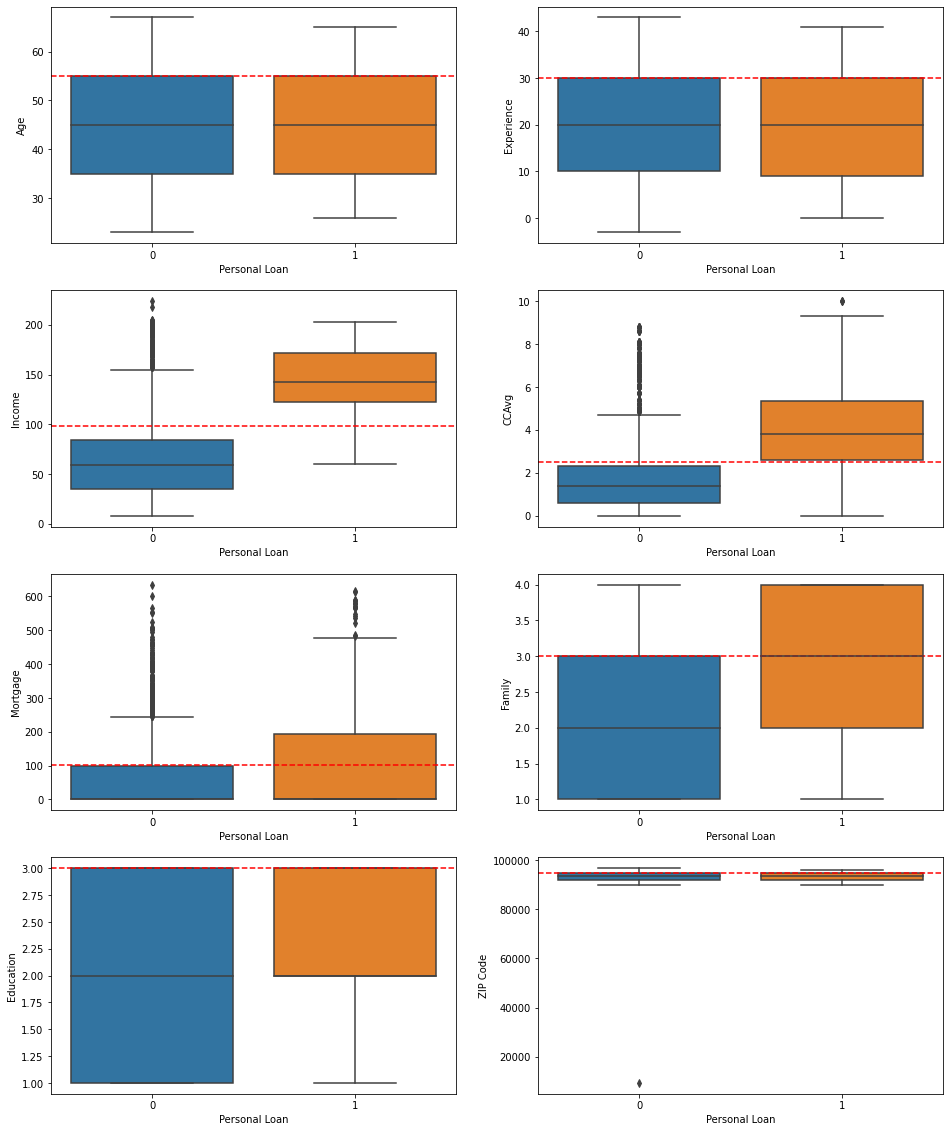

In [233]:
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

for current_column, axis in zip(num_cols, ax.flatten()):
    sns.boxplot(x='Personal Loan', y=current_column, data=df, ax=axis)
    axis.axhline(df.describe().loc['75%', current_column], ls='--', c='red')
    # axis.legend()

In [234]:
# IsSth features
df['IsMortgaged'] = df['Mortgage'] > 0
df['IsFamily'] = df['Family'] > 1
df['IsEducated'] = df['Education'] > 1

# Is > than 75 qq
df['IsMortgaged75'] = (df['Mortgage'] > df.describe().loc['75%', 'Mortgage']) & df['IsMortgaged']
df['IsIncome75'] = df['Income'] > df.describe().loc['75%', 'Income']
df['IsCCAvg75'] = df['CCAvg'] > df.describe().loc['75%', 'CCAvg']

cat_cols += ['IsMortgaged', 'HasFamily', 'IsEducated', 'IsMortgaged75', 'IsIncome75', 'IsCCAvg75']

In [235]:
def split_data(df, y_col='Personal Loan'):
    
    y = df[y_col]
    
    X, X_val, y, y_val = train_test_split(df.drop([y_col, "ID", "ZIP Code", 'Age', 'Education'], 
                                        axis=1),y, test_size=0.04,
                                        shuffle=True, random_state=19)
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2,
                                                         shuffle=True, random_state=19)
    
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)


def normalize_data(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X), (scaler.mean_, scaler.var_)


def predict(model, X_test, y_test):
    # preds = fitted_model.predict(X_test)
    
    try:
        preds = model.predict_proba(X_test)[:, 1]
    except Exception as e:
        print(e.args)
        preds = model.predict(X_test)
        
    scores = {'accuracy': accuracy_score(y_test, model.predict(X_test)),
              'roc_auc': roc_auc_score(y_test, preds),
              'f1': f1_score(y_test, model.predict(X_test))}
    
    return scores

In [236]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = split_data(df)

(X_train.shape, y_train.shape),\
(X_test.shape, y_test.shape),\
(X_val.shape, y_val.shape)

(((3840, 15), (3840,)), ((960, 15), (960,)), ((200, 15), (200,)))

In [237]:
X_train, X_train_stats = normalize_data(X_train)
X_val, X_val_stats = normalize_data(X_val)
X_test, X_test_stats = normalize_data(X_test)

In [242]:
# initializing models, their params and metrics
models = {'RandomForestClassifier': RandomForestClassifier(),
          'LogisticRegression': LogisticRegression(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier()}

params = {'LogisticRegression': {'C': np.linspace(0.01,2,15),
                                 'penalty': ['l1','l2', 'elasticnet', 'none']},
          'RandomForestClassifier': {'max_features': [1,3,10],
                                      'min_samples_split': [2,3,10],
                                      'min_samples_leaf': [1,3,10],
                                      'bootstrap': [False, True],
                                      'n_estimators': [50, 100, 200, 300],
                                      'n_jobs': [-1]},
          'DecisionTreeClassifier': {'splitter': ['best', 'random'],
                                     'max_depth': ['none'] + [i for i in range(3, 9)]},
          'KNeighborsClassifier':  {'n_neighbors': np.arange(1,50),
                                    'weights': ['uniform', 'distance']},
          'GradientBoostingClassifier': {'learning_rate': [0.001,0.01,0.1,0.05],
                                         'n_estimators': [100,500,1000],
                                         'max_depth': [3,5,10],
                                         'min_samples_split': [2,5,10]}
}

metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

In [246]:
def train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test, models=models, 
                       params=params, metrics=metrics, n_jobs=-1, verbose=1, n_splits=5):
    '''
    Returns a matrix (pd.DataFrame) of scores and models
    '''
    
    best_scores={}
    best_estimators={}
    
    df_models = []
    df_training_scores = []
    df_scores = {metric_name:[] for metric_name, _ in metrics.items()}
    
    
    df = pd.DataFrame(columns=['model'] + scores)
    
    
    for model_name, model in models.items():
        search = GridSearchCV(model, param_grid=params[model_name], 
                              cv=StratifiedKFold(n_splits=5), scoring='roc_auc',
                              n_jobs=n_jobs, verbose=verbose).fit(X_train, y_train)
        
        best_scores[model_name] = search.best_score_
        best_estimators[model_name] = search.best_estimator_
        
        print(f'Model: {model_name},\nBest score: \
        {best_scores[model_name]}\nBest params: {best_estimators[model_name]}')            
        
        df_models.append(model_name)

        for score_name, score in metrics.items():
            # f1 and accuracy don't work with probas
            # Also RFClassifier don't have predict_proba
            try:
                preds = search.predict_proba(X_test)
                df_scores[score_name].append(score(y_test, preds))
            except Exception as e:
                preds = search.predict(X_test)
                df_scores[score_name].append(score(y_test, preds))
        
    df['model'] = df_models
        
    for score_name, _ in df_scores.items():
        df[score_name] = df_scores[score_name]
            
    return df, best_estimators, best_scores

In [247]:
%%time
scoring_df, best_params, best_scores = train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Model: RandomForestClassifier,
Best score:         0.9973116836791457
Best params: RandomForestClassifier(max_features=10, n_estimators=300, n_jobs=-1)
Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\vanis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.97066663        nan 0.97467939        nan 0.97419224
        nan 0.97467939        nan 0.97448242        nan 0.97467939
        nan 0.97455062        nan 0.97467939        nan 0.97457063
        nan 0.97467939        nan 0.97461473        nan 0.97467939
        nan 0.97460271        nan 0.97467939        nan 0.97462685
        nan 0.97467939        nan 0.97464711        nan 0.97467939
        nan 0.97467535        nan 0.97467939        nan 0.97468748
        nan 0.97467939        nan 0.9746754         nan 0.97467939
        nan 0.97466343        nan 0.97467939        nan 0.9746553
        nan 0.97467939        nan 0.97465939        nan 0.97467939]
  category=UserWarning


Model: LogisticRegression,
Best score:         0.9746874765393061
Best params: LogisticRegression(C=1.4314285714285715)
Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\vanis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.99276184 0.96597816 0.9890867  0.98438933
 0.98509328 0.98497187 0.97416234 0.98561541 0.96738885 0.96772041
 0.95218119 0.95741308]
  category=UserWarning


Model: DecisionTreeClassifier,
Best score:         0.9927618350466721
Best params: DecisionTreeClassifier(max_depth=3)
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Model: KNeighborsClassifier,
Best score:         0.9793048320080759
Best params: KNeighborsClassifier(n_neighbors=48, weights='distance')
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Model: GradientBoostingClassifier,
Best score:         0.9978089945819846
Best params: GradientBoostingClassifier(learning_rate=0.05, max_depth=10,
                           min_samples_split=10, n_estimators=1000)
Wall time: 11min 24s


In [257]:
scoring_df.to_csv('scoring_df.csv', index=None)

In [258]:
scoring_df = pd.read_csv('scoring_df.csv')

,model,accuracy,roc_auc,precision,recall,f1
0,RandomForestClassifier,0.988542,0.952449,0.977778,0.907216,0.941176
1,LogisticRegression,0.967708,0.867658,0.923077,0.742268,0.822857
2,DecisionTreeClassifier,0.979167,0.906058,0.975309,0.814433,0.887640
3,KNeighborsClassifier,0.951042,0.794334,0.878788,0.597938,0.711656
4,GradientBoostingClassifier,0.981250,0.948394,0.907216,0.907216,0.907216


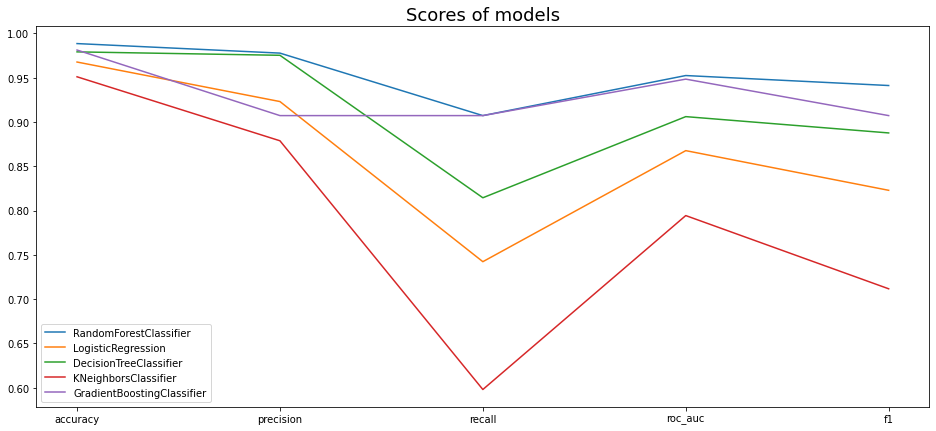

In [307]:
fig = plt.figure(figsize=(16, 7))
for i in range(len(scoring_df)):
    plt.plot(metrics.keys(), scoring_df.loc[i, metrics.keys()].values, label=scoring_df['model'][i])

plt.title('Scores of models', fontsize=18)
# plt.xlabels = metrics.keys()
plt.legend();
